In [3]:
import argparse
import sys
import os
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from easydict import EasyDict as edict
import cv2
import torch
import numpy as np

src_dir = os.path.dirname(os.path.realpath('test'))
while not src_dir.endswith("sfa"):
    src_dir = os.path.dirname(src_dir)
if src_dir not in sys.path:
    sys.path.append(src_dir)
    
from data_process.kitti_dataloader import create_test_dataloader
from models.model_utils import create_model
from utils.misc import make_folder, time_synchronized
from utils.evaluation_utils import decode, post_processing, draw_predictions, convert_det_to_real_values
from utils.torch_utils import _sigmoid
import config.kitti_config as cnf
from data_process.transformation import lidar_to_camera_box
from utils.visualization_utils import merge_rgb_to_bev, show_rgb_image_with_boxes
from data_process.kitti_data_utils import Calibration
import matplotlib.pyplot as plt


In [4]:
def parse_test_configs():
    parser = argparse.ArgumentParser(description='Testing config for the Implementation')
    parser.add_argument('--saved_fn', type=str, default='fpn_resnet_18', metavar='FN',
                        help='The name using for saving logs, models,...')
    parser.add_argument('-a', '--arch', type=str, default='fpn_resnet_18', metavar='ARCH',
                        help='The name of the model architecture')
    parser.add_argument('--pretrained_path', type=str,
                        default='../checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth', metavar='PATH',
                        help='the path of the pretrained checkpoint')
    parser.add_argument('--K', type=int, default=50,
                        help='the number of top K')
    parser.add_argument('--no_cuda', action='store_true',
                        help='If true, cuda is not used.')
    parser.add_argument('--gpu_idx', default=0, type=int,
                        help='GPU index to use.')
    parser.add_argument('--num_samples', type=int, default=None,
                        help='Take a subset of the dataset to run and debug')
    parser.add_argument('--num_workers', type=int, default=1,
                        help='Number of threads for loading data')
    parser.add_argument('--batch_size', type=int, default=1,
                        help='mini-batch size (default: 4)')
    parser.add_argument('--peak_thresh', type=float, default=0.2)
    parser.add_argument('--save_test_output', action='store_true',
                        help='If true, the output image of the testing phase will be saved')
    parser.add_argument('--output_format', type=str, default='image', metavar='PATH',
                        help='the type of the test output (support image or video)')
    parser.add_argument('--output_video_fn', type=str, default='out_fpn_resnet_18', metavar='PATH',
                        help='the video filename if the output format is video')
    parser.add_argument('--output-width', type=int, default=608,
                        help='the width of showing output, the height maybe vary')

#     configs = edict(vars(parser.parse_args()))
    configs = edict()
    configs.saved_fn = 'fpn_resnet_18'
    configs.arch='fpn_resnet_18'
    configs.pretrained_path='../checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth'
    configs.K=50
    configs.no_cuda=False
    configs.gpu_idx=0
    configs.num_samples=None
    configs.num_workers=1
    configs.batch_size=1
    configs.peak_thresh=0.2
    configs.save_test_output=False
    configs.output_format='image'
    configs.output_video_fn='out_fpn_resnet_18'
    configs.output_width=608
    
    
    
    configs.pin_memory = True
    configs.distributed = False  # For testing on 1 GPU only

    configs.input_size = (608, 608)
    configs.hm_size = (152, 152)
    configs.down_ratio = 4
    configs.max_objects = 50

    configs.imagenet_pretrained = False
    configs.head_conv = 64
    configs.num_classes = 3
    configs.num_center_offset = 2
    configs.num_z = 1
    configs.num_dim = 3
    configs.num_direction = 2  # sin, cos

    configs.heads = {
        'hm_cen': configs.num_classes,
        'cen_offset': configs.num_center_offset,
        'direction': configs.num_direction,
        'z_coor': configs.num_z,
        'dim': configs.num_dim
    }
    configs.num_input_features = 4

    ####################################################################
    ##############Dataset, Checkpoints, and results dir configs#########
    ####################################################################
    configs.root_dir = '../'
    configs.dataset_dir = os.path.join(configs.root_dir, 'dataset', 'kitti')

    if configs.save_test_output:
        configs.results_dir = os.path.join(configs.root_dir, 'results', configs.saved_fn)
        make_folder(configs.results_dir)

    return configs


using ResNet architecture with feature pyramid


-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=


Loaded weights from ../checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth

	Done testing the 5th sample, time: 955.1ms, speed 1.05FPS


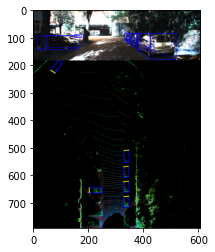

In [5]:
configs = parse_test_configs()

model = create_model(configs)
print('\n\n' + '-*=' * 30 + '\n\n')
assert os.path.isfile(configs.pretrained_path), "No file at {}".format(configs.pretrained_path)
model.load_state_dict(torch.load(configs.pretrained_path, map_location='cpu'))
print('Loaded weights from {}\n'.format(configs.pretrained_path))

configs.device = torch.device('cpu' if configs.no_cuda else 'cuda:{}'.format(configs.gpu_idx))
model = model.to(device=configs.device)

model.eval()

test_dataloader = create_test_dataloader(configs)
with torch.no_grad():
    for batch_idx, batch_data in enumerate(test_dataloader):
        if batch_idx != 5:
            continue
        metadatas, bev_maps, img_rgbs = batch_data
        input_bev_maps = bev_maps.to(configs.device, non_blocking=True).float()
        t1 = time_synchronized()
        outputs = model(input_bev_maps)
        outputs['hm_cen'] = _sigmoid(outputs['hm_cen'])
        outputs['cen_offset'] = _sigmoid(outputs['cen_offset'])
        # detections size (batch_size, K, 10)
        detections = decode(outputs['hm_cen'], outputs['cen_offset'], outputs['direction'], outputs['z_coor'],
                            outputs['dim'], K=configs.K)
        detections = detections.cpu().numpy().astype(np.float32)
        detections = post_processing(detections, configs.num_classes, configs.down_ratio, configs.peak_thresh)
        t2 = time_synchronized()

        detections = detections[0]  # only first batch
        # Draw prediction in the image
        bev_map = (bev_maps.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        bev_map = cv2.resize(bev_map, (cnf.BEV_WIDTH, cnf.BEV_HEIGHT))
        bev_map = draw_predictions(bev_map, detections.copy(), configs.num_classes)

        # Rotate the bev_map
        bev_map = cv2.rotate(bev_map, cv2.ROTATE_180)

        img_path = metadatas['img_path'][0]
        img_rgb = img_rgbs[0].numpy()
        img_rgb = cv2.resize(img_rgb, (img_rgb.shape[1], img_rgb.shape[0]))
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        calib = Calibration(img_path.replace(".png", ".txt").replace("image_2", "calib"))
        kitti_dets = convert_det_to_real_values(detections)
        if len(kitti_dets) > 0:
            kitti_dets[:, 1:] = lidar_to_camera_box(kitti_dets[:, 1:], calib.V2C, calib.R0, calib.P2)
            img_bgr = show_rgb_image_with_boxes(img_bgr, kitti_dets, calib)

        out_img = merge_rgb_to_bev(img_bgr, bev_map, output_width=configs.output_width)

        print('\tDone testing the {}th sample, time: {:.1f}ms, speed {:.2f}FPS'.format(batch_idx, (t2 - t1) * 1000,
                                                                                       1 / (t2 - t1)))
        plt.imshow(out_img)
        break

In [ ]:
from data_process.kitti_dataset import KittiDataset
test_dataset = KittiDataset(configs, mode='test', lidar_aug=None, hflip_prob=0., num_samples=configs.num_samples)
test_dataset.__getitem__(2)

In [42]:
test_dataset.__getitem__(2)[1].shape

torch.Size([3, 608, 608])

In [44]:
batch_data[1].shape

torch.Size([1, 3, 608, 608])

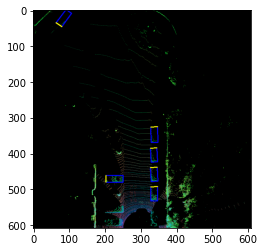

In [45]:
with torch.no_grad():
#     batch_data = next(iter(test_dataloader))
#     batch_idx += 1
#     for batch_idx, batch_data in enumerate(test_dataloader):
#     batch_data = test_dataset.__getitem__(0)
    for batch_idx, batch_data in enumerate(test_dataloader):
        if batch_idx == 5:
            break
    metadatas, bev_maps, img_rgbs = batch_data
    input_bev_maps = bev_maps.to(configs.device, non_blocking=True).float()
    t1 = time_synchronized()
    outputs = model(input_bev_maps)
    outputs['hm_cen'] = _sigmoid(outputs['hm_cen'])
    outputs['cen_offset'] = _sigmoid(outputs['cen_offset'])
    # detections size (batch_size, K, 10)
    detections = decode(outputs['hm_cen'], outputs['cen_offset'], outputs['direction'], outputs['z_coor'],
                        outputs['dim'], K=configs.K)
    detections = detections.cpu().numpy().astype(np.float32)
    detections = post_processing(detections, configs.num_classes, configs.down_ratio, configs.peak_thresh)
    t2 = time_synchronized()

    detections = detections[0]  # only first batch
    # Draw prediction in the image
    bev_map = (bev_maps.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    bev_map = cv2.resize(bev_map, (cnf.BEV_WIDTH, cnf.BEV_HEIGHT))
    bev_map = draw_predictions(bev_map, detections.copy(), configs.num_classes)

    # Rotate the bev_map
    bev_map = cv2.rotate(bev_map, cv2.ROTATE_180)
    plt.imshow(bev_map)
#     img_path = metadatas['img_path'][0]
#     img_rgb = img_rgbs[0].numpy()
#     img_rgb = cv2.resize(img_rgb, (img_rgb.shape[1], img_rgb.shape[0]))
#     img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
#     calib = Calibration(img_path.replace(".png", ".txt").replace("image_2", "calib"))
#     kitti_dets = convert_det_to_real_values(detections)
#     if len(kitti_dets) > 0:
#         kitti_dets[:, 1:] = lidar_to_camera_box(kitti_dets[:, 1:], calib.V2C, calib.R0, calib.P2)
#         img_bgr = show_rgb_image_with_boxes(img_bgr, kitti_dets, calib)

#     out_img = merge_rgb_to_bev(img_bgr, bev_map, output_width=configs.output_width)

#     print('\tDone testing the {}th sample, time: {:.1f}ms, speed {:.2f}FPS'.format(batch_idx, (t2 - t1) * 1000,
#                                                                                    1 / (t2 - t1)))
#     plt.imshow(out_img)
#         break

In [47]:
detections

{0: array([], shape=(0, 8), dtype=float32),
 1: array([[ 9.9476779e-01,  2.6997653e+02,  1.4919400e+02,  1.1672249e+00,
          1.5779747e+00,  1.8248581e+01,  3.9037907e+01, -4.7039449e-02],
        [ 9.8359114e-01,  2.7006769e+02,  9.5130112e+01,  1.1015692e+00,
          1.6019249e+00,  1.9078009e+01,  3.9853722e+01, -1.6671989e-02],
        [ 9.6891868e-01,  3.8053116e+02,  1.3692317e+02,  1.1003773e+00,
          1.4524968e+00,  1.8643044e+01,  4.7673321e+01, -1.5801451e+00],
        [ 8.5580689e-01,  2.7039139e+02,  2.0372755e+02,  1.2471219e+00,
          1.5640763e+00,  1.7898066e+01,  3.8969612e+01, -3.4219086e-02],
        [ 8.3636934e-01,  2.6932660e+02,  2.6019980e+02,  1.3000042e+00,
          1.5951176e+00,  1.8858624e+01,  4.3396664e+01, -1.6714649e-02],
        [ 4.6694493e-01,  5.2188275e+02,  5.8550092e+02,  1.3250047e+00,
          1.5015062e+00,  1.9539347e+01,  4.6416046e+01, -2.5029483e+00]],
       dtype=float32),
 2: array([], shape=(0, 8), dtype=float32)}